In [1]:
import numpy as np 
import pandas as pd
import sklearn

import os

In [2]:
import seaborn as sns
import matplotlib as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from plotnine import *

In [3]:
trainData = pd.read_csv("./data/train.csv")
testData = pd.read_csv("./data/test.csv")

In [4]:
trainData[["BsmtFullBath","BsmtHalfBath","FullBath","HalfBath"]]

,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath
0,1,0,2,1
1,0,1,2,0
2,1,0,2,1
3,1,0,1,0
4,1,0,2,1
5,1,0,1,1
6,1,0,2,0
7,1,0,2,1
8,0,0,2,0
9,1,0,1,0


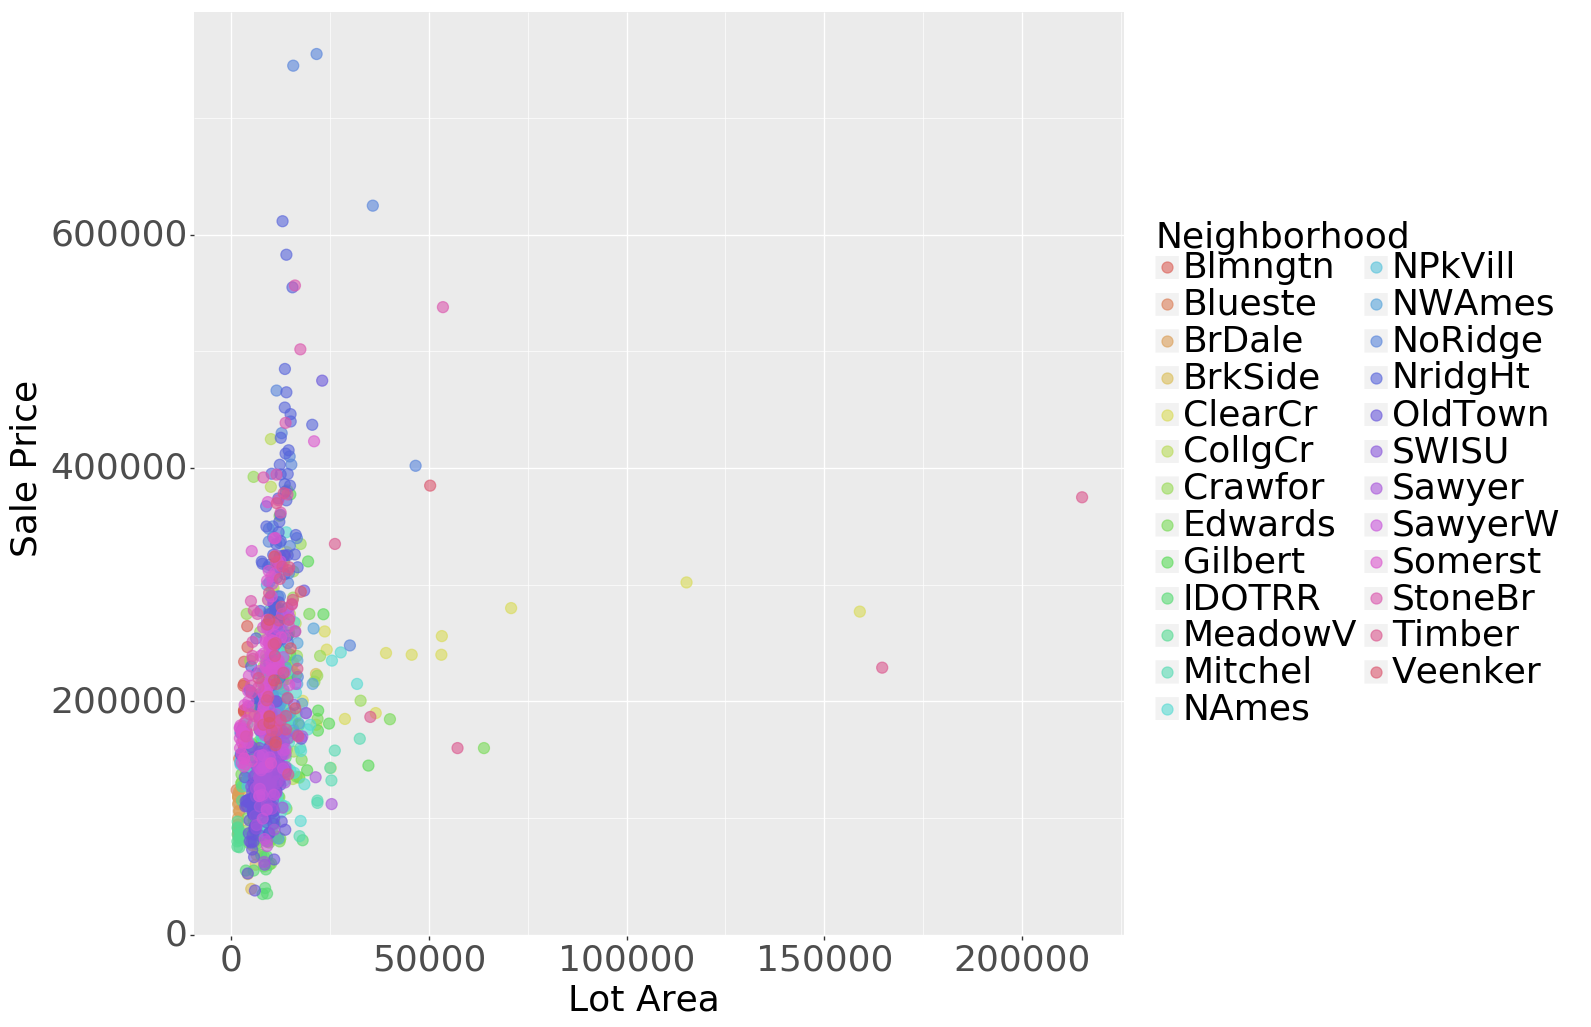

<ggplot: (8794956398554)>

In [15]:
(ggplot(trainData, aes(x="LotArea",y="SalePrice")) + geom_point(aes(color="Neighborhood"),size=4,alpha=0.6) 
 + theme(figure_size=(12,12), text=element_text(size=26)) 
 + xlab("Lot Area")) + ylab("Sale Price")

In [9]:
(trainData["2ndFlrSF"] == 0).sum()

829

In [28]:
fillNone = ["MasVnrType", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "GarageType", "GarageFinish",
            "Fence", "MiscFeature", "MasVnrType", "LotShape", "LandSlope", "Neighborhood",
            "Condition1", "LotConfig", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", 
             "Foundation", "Heating", "SaleCondition", "Electrical", "PavedDrive"]

cat_to_int = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
              'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

In [29]:
[value for value in fillNone if value in cat_to_int]

[]

In [4]:
outliers = ((trainData.GrLivArea > 4000) & (trainData.SalePrice < 5E5))
trainData = trainData[~(outliers)]

In [5]:
zoning = trainData.groupby("Neighborhood").MSZoning.apply(lambda x: x.value_counts().sort_values().index[0]).to_dict()
utilities = trainData.groupby("Neighborhood").Utilities.apply(lambda x: x.value_counts().sort_values().index[0]).to_dict()
frontage = trainData.groupby("Neighborhood").LotFrontage.apply(lambda x: x.value_counts().sort_values().index[0]).to_dict()

In [96]:
trainBoro = trainData.groupby("Neighborhood")["Id"].apply(list).to_dict()
testBoro = testData.groupby("Neighborhood")["Id"].apply(list).to_dict()

In [6]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [ ]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, 

In [7]:
# Don't know what to do with these yet
# Maybe harmonic transform on month. 
# Maybe diff between year sold and built
timeVars = ["MoSold","YrSold","YearBuilt"]

# CentralAir needs to be examined for correlation
toInclude = ["LotFrontage","Electrical","Functional","MSZoning","Utilities",
            "KitchenQual","SaleType","Exterior1st","Exterior2nd","CentralAir"]

In [8]:
## These variables differ for nonlinear models (linearly dependent features)
# values that null is filled with "None"
fillNone = ["Alley","BsmtQual","BsmtCond","MasVnrType","BsmtExposure","BsmtFinType1","BsmtFinType2",
            "FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond",
            "PoolQC","Fence","MiscFeature","MasVnrType","Street", "Alley","LotShape","LandSlope","Neighborhood",
           "Condition1","LotConfig","Condition2","BldgType","HouseStyle","RoofStyle","RoofMatl","ExterQual",
           "ExterCond","Foundation","Heating","HeatingQC","SaleCondition", "MSZoning","Electrical"]

# ordinal categorical variables
fillZeroCat = ["BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","GarageCars","MSSubClass",
              "OverallQual","OverallCond","TotrmsAbvGrd"]

# continuous variables with missing values that are zero
fillZeroCont = ["MasVnrArea","GarageArea","GrLivArea","1stFlrSF","2ndFlrSF",
                "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF", "TotalBsmtSF","LotArea","EnclosedPorch","3SsnPorch",
               "ScreenPorch","MiscVal","LotFrontage"]

# variables that need differences between reference engineered
imputeDiff = [("GarageYrBlt","YearBuilt"),("YearRemodAdd","YearBuilt")]

# categories that we need to know if they were imputed
imputeUnknown = []

# to be dropped
dropList = ["Id"]

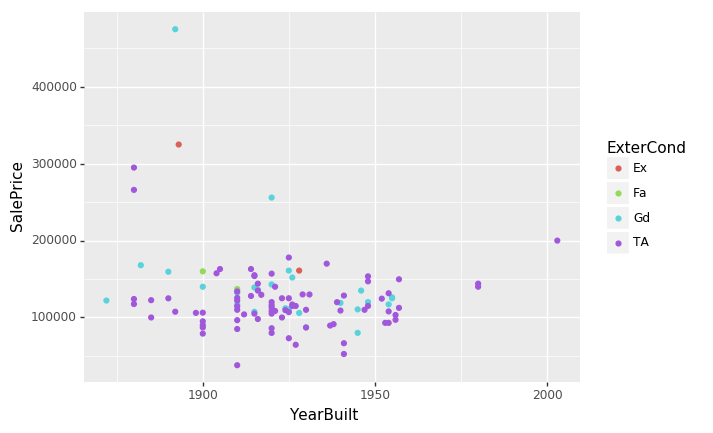

<ggplot: (8730823225320)>

In [111]:
(ggplot(trainData[trainData.Neighborhood == "OldTown"], aes(x="YearBuilt",y="SalePrice")) + 
        geom_point(aes(color="ExterCond")))

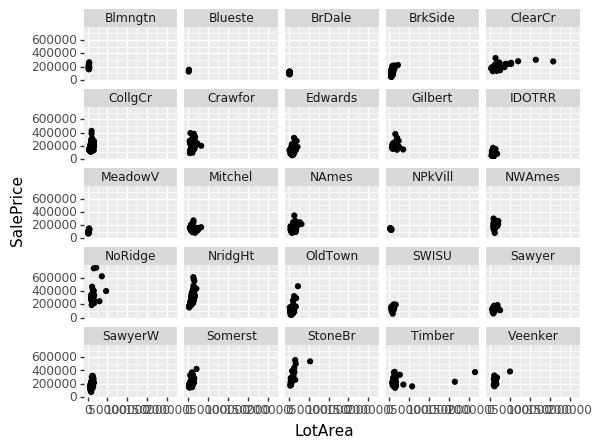

<ggplot: (8730822914494)>

In [103]:
ggplot(trainData, aes(x="LotArea",y="SalePrice")) + geom_point() + facet_wrap("Neighborhood")

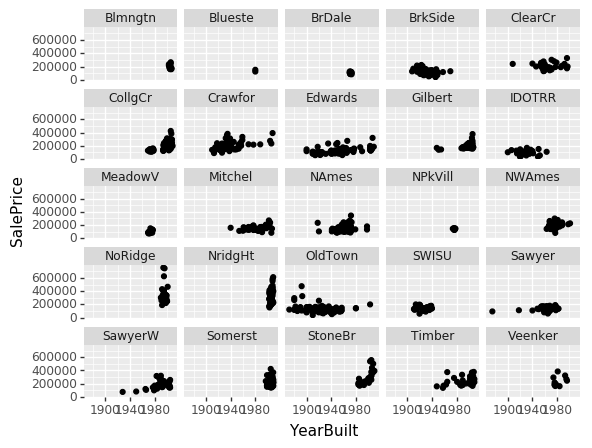

<ggplot: (8730823509452)>

In [102]:
ggplot(trainData, aes(x="YearBuilt",y="SalePrice")) + geom_point() + facet_wrap("Neighborhood")

In [70]:
## These are for the linear model
selected=[]
# values that null is filled with "None"
fillNone = ["Alley","BsmtQual","MasVnrType","BsmtExposure","BsmtFinType1","BsmtFinType2",
            "GarageType","GarageFinish","GarageQual","GarageCond","BsmtCond","FireplaceQu",
            "PoolQC","Fence","MiscFeature","MasVnrType","MSZoning",
            "LotShape","LandSlope",
           "Condition1","LotConfig","Condition2","BldgType","HouseStyle","RoofStyle","RoofMatl","ExterQual",
           "ExterCond","Foundation","Heating","HeatingQC","SaleCondition", "Electrical"]

# ordinal categorical variables
fillZeroCat = ["BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr",
              "OverallQual","OverallCond","MSSubClass"]

# continuous variables with missing values that are zero
fillZeroCont = ["MasVnrArea","GarageArea","GrLivArea","1stFlrSF","2ndFlrSF","LotFrontage",
                "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","WoodDeckSF","OpenPorchSF","PoolArea",
                 "LotArea","EnclosedPorch","3SsnPorch",
               "ScreenPorch","MiscVal","LotFrontage","FullBath","Fireplaces","TotRmsAbvGrd"]

# variables that need differences between reference engineered
imputeDiff = [("GarageYrBlt","YearBuilt"),("YearRemodAdd","YearBuilt")]

# imputed to boolean: passthrough
imputeBool = ["PavedDrive","CentralAir"]

# categories that we need to know if they were imputed
imputeUnknown = []

# List of values taken out to be onehotencoded with a list argument
# Due to missing values in test data
handleMissingInt = ["FullBath","GarageCars","Fireplaces","TotRmsAbvGrd"]
handleMissingCat = []

# to be dropped
dropList = ["TotalBsmtSF","Id","GarageYrBlt","YearRemodAdd","GarageCars","Street","Alley","Utilities"]

imputeDict = {"Electrical": "SBrkr", 
              "Functional": "Typ", 
              "CentralAir":"Y",
              "KitchenQual":"Fa",
              "SaleType":"Oth",
              "Exterior1st":"VinylSd",
              "Exterior2nd":"VinylSd"}

In [71]:
def imputeVals2(in_df):
    df = in_df.copy()
    df.LotFrontage = df.LotFrontage.fillna(df.Neighborhood.map(frontage))  
    df.MSZoning = df.MSZoning.fillna(df.Neighborhood.map(zoning))
    df.Utilities = df.Utilities.fillna(df.Neighborhood.map(utilities))
    df["PavedDrive"] = (df["PavedDrive"] == "Y")
    df["CentralAir"] = (df["CentralAir"] == "Y")
    df.MSSubClass[df.MSSubClass==150] = 120
    return df

In [72]:
train_X = trainData.drop(columns=["SalePrice"])
train_y = trainData.SalePrice

In [74]:
pipe_X = imputeVals2(train_X)

In [73]:
from sklearn.base import BaseEstimator, TransformerMixin

class dictImputer(BaseEstimator,TransformerMixin):
    def __init__(self,dict_: dict):
        self.dict_ = dict_
         
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        for k,v in self.dict_.items():
            X[k] = X[k].fillna(v)
        return X[self.dict_.keys()]  
    
## Example:
# dictImputer(imputeDict).fit_transform(pipe_X)

In [75]:
nonePipeline = make_pipeline(SimpleImputer(strategy="constant",fill_value="None"),OneHotEncoder(handle_unknown="ignore"))
zeroPipeline = make_pipeline(SimpleImputer(strategy="constant",fill_value=0),OneHotEncoder(handle_unknown="ignore"))
scalePipeline = make_pipeline(SimpleImputer(strategy="constant",fill_value=0),StandardScaler())

nonePipeline = make_pipeline(SimpleImputer(strategy="constant",fill_value="None"),OneHotEncoder(drop="first"))
zeroPipeline = make_pipeline(SimpleImputer(strategy="constant",fill_value=0),OneHotEncoder(drop="first",categories="auto"))
scalePipeline = make_pipeline(SimpleImputer(strategy="constant",fill_value=0),StandardScaler())

regressionPipeline = ColumnTransformer([
    ("setNone", nonePipeline,fillNone),
    ("setZero", zeroPipeline,fillZeroCat),
    ("transformed", scalePipeline, fillZeroCont),
    ("dictImputed", make_pipeline(dictImputer(imputeDict),OneHotEncoder(drop="first")),list(imputeDict.keys())),
    ("bool", "passthrough", imputeBool),
    ("dropped", "drop", dropList)
],remainder="drop")



In [76]:
piped_X = regressionPipeline.fit_transform(pipe_X)

In [77]:
targetScaler =  StandardScaler()
pipe_y = targetScaler.fit_transform(np.log(train_y.values.reshape(-1,1)))

In [22]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import GridSearchCV

In [23]:
lm = ElasticNet()

In [37]:
search1 = {"alpha": np.logspace(-5,2,50), "l1_ratio": np.linspace(0,1,50)}
search2 = {"alpha": np.logspace(-4,0,25), "l1_ratio": np.linspace(.55,.65,25)}

lm_grid = GridSearchCV(lm, search2, cv = 5, scoring = "neg_mean_squared_error", n_jobs = -1, verbose=50)
lm_grid.fit(piped_X,pipe_y)

Fitting 5 folds for each of 625 candidates, totalling 3125 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:  1.2min
[Paralle

[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 283 tasks      | elapsed:  2.3min
[Paralle

[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 414 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 415 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:  3.2min
[Paralle

[Parallel(n_jobs=-1)]: Done 535 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 539 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 542 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 543 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 547 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 548 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 549 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 550 tasks      | elapsed:  3.8min
[Paralle

[Parallel(n_jobs=-1)]: Done 671 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 673 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 675 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 678 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 679 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 681 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 683 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 684 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 685 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 686 tasks      | elapsed:  4.3min
[Paralle

[Parallel(n_jobs=-1)]: Done 806 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 807 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 809 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 811 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 813 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 814 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 815 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 817 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 819 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 820 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 821 tasks      | elapsed:  4.7min
[Paralle

[Parallel(n_jobs=-1)]: Done 940 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 941 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 942 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 943 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 945 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 946 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 947 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 948 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 949 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 950 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 951 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 954 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 955 tasks      | elapsed:  5.0min
[Paralle

[Parallel(n_jobs=-1)]: Done 1072 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1073 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1074 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1075 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1076 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1077 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1078 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1079 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1081 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1082 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1083 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1084 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1085 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1086 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1087 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1204 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1205 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1206 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1207 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1208 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1209 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1211 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1212 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1213 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1214 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1215 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1216 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1217 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1219 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1335 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1337 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1338 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1339 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1340 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1341 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1342 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1343 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1344 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1345 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1346 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1347 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1348 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1349 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1350 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1467 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1468 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1469 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1470 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1471 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1472 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1473 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1474 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1475 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1476 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1477 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1478 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1479 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1480 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1481 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1482 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1602 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1603 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1604 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1605 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1606 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1607 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1608 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1609 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1610 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1611 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1612 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1613 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1614 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1615 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1616 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1617 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1737 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1738 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1739 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1740 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1741 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1742 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1743 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1744 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1745 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1746 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1747 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1748 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1749 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1750 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1751 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1870 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1871 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1872 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1873 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1874 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1875 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1876 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1877 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1878 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1879 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1880 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1881 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1882 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1883 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1884 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1885 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2003 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2004 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2005 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2006 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1985s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done 2007 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2009 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2010 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2011 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2012 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2013 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2015 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2017 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2019 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2021 ta

[Parallel(n_jobs=-1)]: Done 2257 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2259 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1999s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 2261 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2263 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2265 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2267 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2269 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2271 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2273 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2277 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2281 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2285 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2289 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2293 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2297 ta

[Parallel(n_jobs=-1)]: Done 3017 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 3025 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 3033 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 3041 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 3049 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 3057 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 3065 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 3073 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 3125 out of 3125 | elapsed:  6.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 1.46779927e-04, 2.15443469e-04, 3.16...
                         'l1_ratio': array([0.55      , 0.55416667, 0.55833333, 0.5625    , 0.56666667,
       0.57083333, 0.575     , 0.57916667, 0.58333333, 0.5875    ,
       0.59166667, 0.59583333, 0.6       , 0.60416667, 0.60833333,
       0.6125    , 0.61666667, 0.62083333, 0.625     , 0.62916667,
       0.63333333, 0.6375    , 0.64166667, 0.64583333, 0.65      ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,


In [38]:
lm_grid.best_params_

{'alpha': 0.001, 'l1_ratio': 0.5958333333333333}

In [39]:
lm_grid.best_score_

-0.0870927537926076

In [78]:
lm_params1 = {'alpha': 0.013894954943731374, 'l1_ratio': 0.02040816326530612}
lm_params2 = {}

test_net = ElasticNet(**lm_grid.best_params_)
#test_net = ElasticNet(**lm_params)

test_net.fit(piped_X,pipe_y)
test_net.score(piped_X,pipe_y)

0.9342285900799616

In [79]:
piped_test_X = regressionPipeline.transform(imputeVals2(testData))

In [42]:
raw_preds = test_net.predict(piped_test_X)

In [43]:
outvals = np.exp(targetScaler.inverse_transform(raw_preds))

In [44]:
submit_frame = pd.DataFrame()
submit_frame['Id'] = testData.Id
submit_frame['SalePrice'] = outvals
submit_frame.to_csv('submission.csv',index=False)

{'alpha': 0.013894954943731374, 'l1_ratio': 0.02040816326530612}